In [1]:
import os
import sys
import requests

# Add the `scripts` directory to the Python path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, "../"))
sys.path.append(scripts_dir)

# Import the generate_mnist_test_files function

from generate_input_files.generate_mnist_xdataset_test_files import generate_mnist_xdataset_test_files

Make sure the API is running on localhost:8000 - Without Authentication!!

In [2]:
# Define paths and configurations
root_dir = os.path.abspath("../..")
tmp_folder = os.path.join(root_dir, "tmp", "increasing_dataset_test_storage")
API_URL = "http://localhost:8000/developer/submit_job_by_model_and_data"
MINIO_URL = "http://localhost:9000"
ACCESS_KEY = "minio_user"  # Replace with your MinIO access key
SECRET_KEY = "minio_password"  # Replace with your MinIO secret key
BUCKET_NAME = "training-jobs"
DOWNLOAD_DIR = os.path.join(root_dir, "results", "storage", "increasing_dataset_test_storage")

# Step 1: Generate MNIST test files with multiple datasets
dataset_sizes = [100, 200, 300, 400, 500]  # Number of images per class
print("Generating MNIST test files with increasing dataset sizes...")
generated_files = generate_mnist_xdataset_test_files(tmp_folder, dataset_sizes)
print("File generation completed.")

# Extract file paths
dataset_files = generated_files["datasets"]
yaml_files = generated_files["yamls"]
model_file = generated_files["model"]

Generating MNIST test files with increasing dataset sizes...
MNIST dataset with 100 images per class saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_dataset_test_storage\mnist_dataset_100
Dataset definition for 100 images per class saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_dataset_test_storage\mnist_definition_100.yaml
Dataset zipped to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_dataset_test_storage\mnist_dataset_100.zip
MNIST dataset with 200 images per class saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_dataset_test_storage\mnist_dataset_200
Dataset definition for 200 images per class saved to c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\tmp\increasing_dataset_test_storage\mnist_definition_200.yaml
Dataset zipped to c:\Users\wiebe\Desktop\.

In [3]:
from generate_input_files.download_results import initialize_s3_client, wait_for_job_and_download
import boto3

# Initialize the S3 client
s3_client = initialize_s3_client(MINIO_URL, ACCESS_KEY, SECRET_KEY)

# Define the dataset sizes to test
dataset_mapping = {}  # Dictionary to map dataset size to unique_dir and job_id

# Step 2: Submit jobs with increasing dataset sizes
for dataset_file, yaml_file, size in zip(dataset_files, yaml_files, dataset_sizes):
    print(f"\nSubmitting job with dataset size {size} images per class...")

    # Prepare the files and data for the request
    files = {
        "model": open(model_file, "rb"),
        "dataset": open(dataset_file, "rb"),
        "dataset_definition": open(yaml_file, "rb"),
    }
    data = {
        "framework": "TensorFlow 2.16.1",
        "model_name": f"storage_analysis_dataset_{size}_images",
        "epochs": "1",
    }

    # Submit the job
    response = requests.post(API_URL, files=files, data=data)
    print(f"Submitted: {response.status_code} {response.text}")

    # Extract the unique_dir and job_id from the API response
    response_data = response.json()
    unique_dir = response_data.get("unique_dir")
    job_id = response_data.get("job_id")  # Assuming the API returns a job_id
    if not unique_dir:
        raise ValueError("Error: 'unique_dir' not found in the API response.")

    # Store the mapping
    dataset_mapping[size] = {"unique_dir": unique_dir, "job_id": job_id}

    # Wait for the job to finish and download the results
    print(f"Waiting for job with dataset size {size} images per class to complete...")
    wait_for_job_and_download(s3_client, BUCKET_NAME, unique_dir, DOWNLOAD_DIR)
    print(f"Artifacts for dataset size {size} images per class downloaded to: {DOWNLOAD_DIR}")


Submitting job with dataset size 100 images per class...
Submitted: 200 {"job_id":"37324b9e-d30f-40c1-b686-fd322d0f310b","status":"Training started","unique_dir":"a45b5462-e3dd-4757-a79b-879ea63f4c88"}
Waiting for job with dataset size 100 images per class to complete...
Checking if job is finished by looking for 'output' folder in 'a45b5462-e3dd-4757-a79b-879ea63f4c88'...
Job is not yet finished. Retrying in 10 seconds...
Checking if job is finished by looking for 'output' folder in 'a45b5462-e3dd-4757-a79b-879ea63f4c88'...
Downloaded: a45b5462-e3dd-4757-a79b-879ea63f4c88/dataset/mnist_dataset_100.zip -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\storage\increasing_dataset_test_storage\a45b5462-e3dd-4757-a79b-879ea63f4c88/dataset/mnist_dataset_100.zip
Downloaded: a45b5462-e3dd-4757-a79b-879ea63f4c88/definition/mnist_definition_100.yaml -> c:\Users\wiebe\Desktop\.ugent20242025\masterproef_local\AIBoMGen-experiments\results\storage\increasing_d

   Dataset Size (Images per Class)  Dataset Size (KB)  Definition Size (KB)  \
0                              100         384.123047              0.150391   
1                              200         765.177734              0.150391   
2                              300        1153.446289              0.150391   
3                              400        1537.126953              0.150391   
4                              500        1923.439453              0.150391   

   Input Model Size (KB)  Trained Model Size (KB)  AIBOM Size (KB)  \
0             2738.69043              8163.098633        13.473633   
1             2738.69043              8163.098633        13.476562   
2             2738.69043              8163.098633        13.477539   
3             2738.69043              8163.098633        13.476562   
4             2738.69043              8163.098633        13.477539   

   Logs Size (KB)  Metrics Size (KB)  RunLink Size (KB)  \
0        4.251953           0.127930         

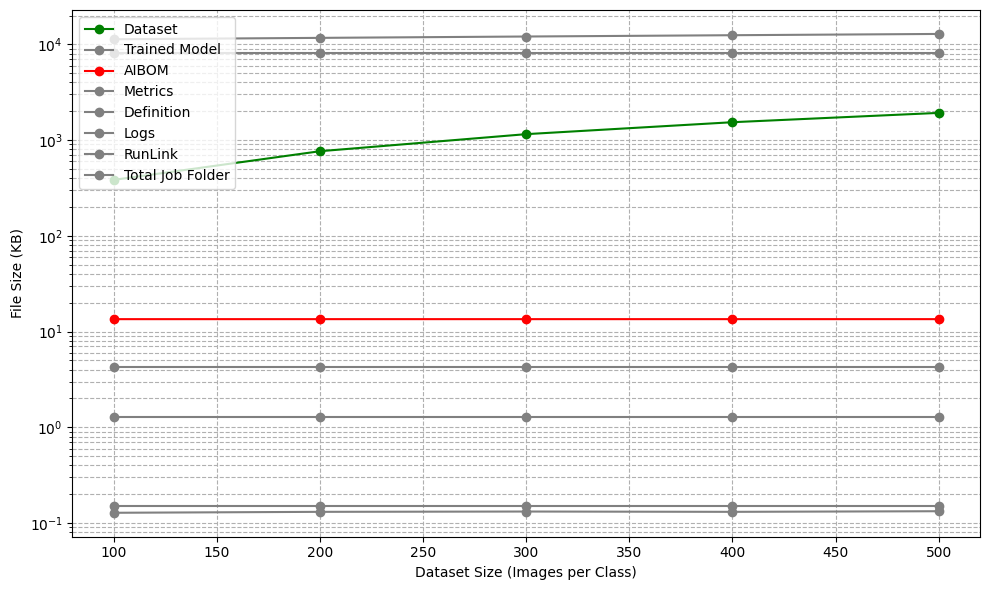

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Analyze Storage Data
# Define the path to the job result folders
results_dir = Path(DOWNLOAD_DIR)  # Use the DOWNLOAD_DIR defined earlier

# Extract data for analysis
dataset_sizes_list = list(dataset_mapping.keys())  # Extract dataset sizes from the mapping
dataset_sizes = []
definition_sizes = []
model_sizes = []
trained_model_sizes = []
aibom_sizes = []
logs_sizes = []
metrics_sizes = []
runlink_sizes = []
total_folder_sizes = []

# Process each job folder
for size, info in dataset_mapping.items():
    unique_dir = info["unique_dir"]
    folder_path = results_dir / unique_dir

    # Top-level files
    dataset_file = folder_path / "dataset" / f"mnist_dataset_{size}.zip"
    definition_file = folder_path / "definition" / f"mnist_definition_{size}.yaml"
    model_file = folder_path / "model" / "mnist_model.keras"
    # Output files
    output_path = folder_path / "output"
    trained_model_file = output_path / "trained_model.keras"
    aibom_file = output_path / "cyclonedx_bom.json"
    logs_file = output_path / "logs.log"
    metrics_file = output_path / "metrics.json"
    runlink_file = next(output_path.glob("run_training.*.link"), None)

    # Get sizes in KB (handle missing files gracefully)
    dataset_sizes.append(dataset_file.stat().st_size / 1024 if dataset_file.exists() else None)
    definition_sizes.append(definition_file.stat().st_size / 1024 if definition_file.exists() else None)
    model_sizes.append(model_file.stat().st_size / 1024 if model_file.exists() else None)
    trained_model_sizes.append(trained_model_file.stat().st_size / 1024 if trained_model_file.exists() else None)
    aibom_sizes.append(aibom_file.stat().st_size / 1024 if aibom_file.exists() else None)
    logs_sizes.append(logs_file.stat().st_size / 1024 if logs_file.exists() else None)
    metrics_sizes.append(metrics_file.stat().st_size / 1024 if metrics_file.exists() else None)
    runlink_sizes.append(runlink_file.stat().st_size / 1024 if runlink_file and runlink_file.exists() else None)

    # Calculate total folder size in KB
    total_size = sum(f.stat().st_size for f in folder_path.rglob('*') if f.is_file()) / 1024
    total_folder_sizes.append(total_size)

# Create a DataFrame for analysis
df = pd.DataFrame({
    "Dataset Size (Images per Class)": dataset_sizes_list,
    "Dataset Size (KB)": dataset_sizes,
    "Definition Size (KB)": definition_sizes,
    "Input Model Size (KB)": model_sizes,
    "Trained Model Size (KB)": trained_model_sizes,
    "AIBOM Size (KB)": aibom_sizes,
    "Logs Size (KB)": logs_sizes,
    "Metrics Size (KB)": metrics_sizes,
    "RunLink Size (KB)": runlink_sizes,
    "Total Job Folder Size (KB)": total_folder_sizes,
    "AIBOM % of Trained Model": [100 * a / m if m else None for a, m in zip(aibom_sizes, trained_model_sizes)]
})
print(df)

df.to_csv(os.path.join(DOWNLOAD_DIR, "storage_analysis_dataset_results.csv"), index=False)


# Plot 1: File Sizes vs Dataset Size (Log Scale)
plt.figure(figsize=(10, 6))
plt.plot(df["Dataset Size (Images per Class)"], df["Dataset Size (KB)"], marker='o', label="Dataset", color="green")
plt.plot(df["Dataset Size (Images per Class)"], df["Trained Model Size (KB)"], marker='o', label="Trained Model", color="gray")
plt.plot(df["Dataset Size (Images per Class)"], df["AIBOM Size (KB)"], marker='o', label="AIBOM", color="red")
plt.plot(df["Dataset Size (Images per Class)"], df["Metrics Size (KB)"], marker='o', label="Metrics", color="gray")
plt.plot(df["Dataset Size (Images per Class)"], df["Definition Size (KB)"], marker='o', label="Definition", color="gray")
plt.plot(df["Dataset Size (Images per Class)"], df["Logs Size (KB)"], marker='o', label="Logs", color="gray")
plt.plot(df["Dataset Size (Images per Class)"], df["RunLink Size (KB)"], marker='o', label="RunLink", color="gray")
plt.plot(df["Dataset Size (Images per Class)"], df["Total Job Folder Size (KB)"], marker='o', label="Total Job Folder", color="gray")

plt.xlabel("Dataset Size (Images per Class)")
plt.ylabel("File Size (KB)")
plt.yscale("log")
plt.legend(loc="upper left")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()
